In [1]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
TOTAL_EXPERIMENTS = 2000
K = 10
TIMESTEPS = 1000

avg_scores = {}
optimal_action = {}

In [3]:
class Bandit:
    def __init__(self, batch_size, k, mean=0):
        self.k = k
        self.batch_size = batch_size
        # True Values generated from Normal Distribution
        self.true_values = np.random.normal(mean ,1 ,(batch_size, k))
        self.predicted_values = np.zeros((batch_size, k),dtype=np.float64)
        self.n_actions = np.zeros((batch_size, k),dtype=np.float64)
        self.average_scores = []
        self.optimal_predictions = []
        self.actions = []
        #self.action_preferences = np.zeros((batch_size, k),dtype=np.float64)
        #self.average_values = np.zeros((batch_size),dtype=np.float64)
    
    def update_predicted_values(self, predicted_values):
        self.predicted_values = predicted_values
        
    def get_reward(self, action_indexes, n):
        # Rewards estimated using mu = q*(a), std = 1
        mu = self.true_values[range(self.batch_size), action_indexes]
        rewards = np.random.normal(mu, 1, self.batch_size)
        self.average_scores.append(rewards.mean())
        optimal_actions = np.argmax(self.true_values, axis=1)
        optimal_precentage = np.sum(np.equal(optimal_actions, action_indexes))/self.batch_size
        self.optimal_predictions.append(optimal_precentage)
        return rewards

In [4]:
def plot_figures(avg_scores, optimal_action, keys):
    x = range(TIMESTEPS)
    
    plt.figure(figsize=(20,10))
    for k,v in avg_scores.items():
        if k in keys:
            plt.plot(x, v, label=str(k))
    plt.legend(loc='lower right', shadow=True, fontsize='x-large')
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.show()

    plt.figure(figsize=(20,10))
    for k,v in optimal_action.items():
        if k in keys:
            plt.plot(x, v, label=str(k))
    plt.legend(loc='lower right', shadow=True, fontsize='x-large')
    plt.xlabel('Steps')
    plt.ylabel('Optimal Action')
    plt.show()

In [11]:
class EpsilonGreedy(Bandit):
    def __init__(self, batch_size, k, mean=0, epsilon=0):
        super(EpsilonGreedy, self).__init__(batch_size, k, mean)
        self.epsilon = epsilon
        
    def get_actions(self):
        action_indexes = np.argmax(self.predicted_values, axis=1)
        eps = np.random.rand(self.batch_size)
        random_choice = np.random.choice(self.k, self.batch_size)
        action_indexes = np.where(eps<self.epsilon, random_choice, action_indexes)
        return action_indexes
    
    def update(self, rewards, action_indexes, n):
        self.n_actions[range(self.batch_size), action_indexes] += 1
        self.predicted_values[range(self.batch_size), action_indexes] += (rewards - self.predicted_values[range(self.batch_size), action_indexes])/self.n_actions[range(self.batch_size), action_indexes]
        
    def run(self, timesteps):
        for i in range(1, timesteps + 1):
            action_indexes = self.get_actions()
            rewards = self.get_reward(action_indexes, i)
            self.update(rewards, action_indexes, i)
        return self.average_scores, self.optimal_predictions

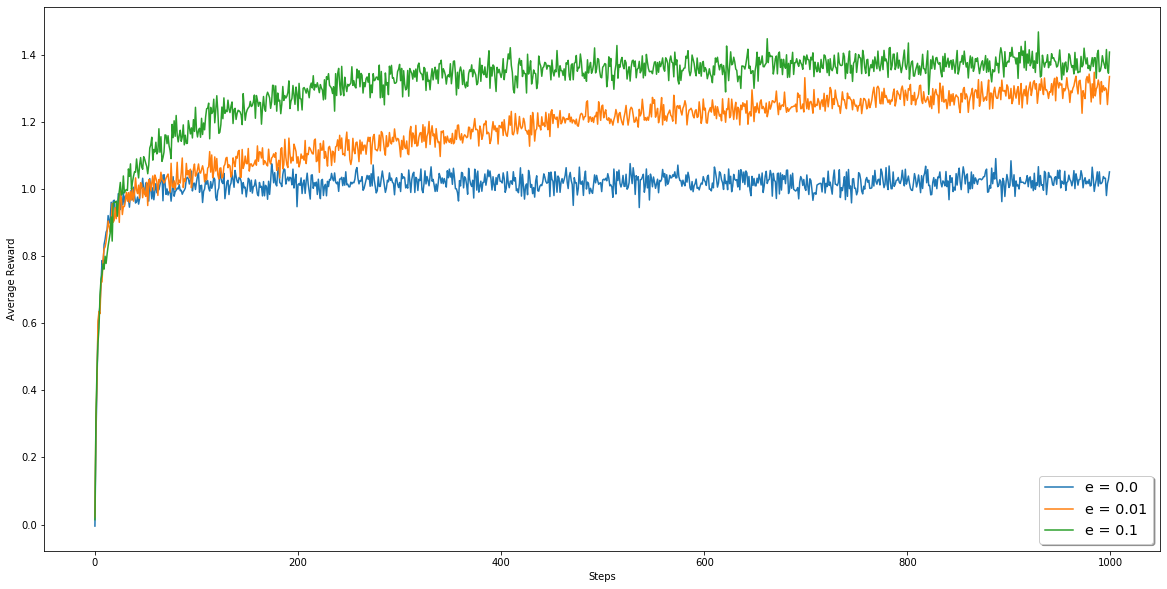

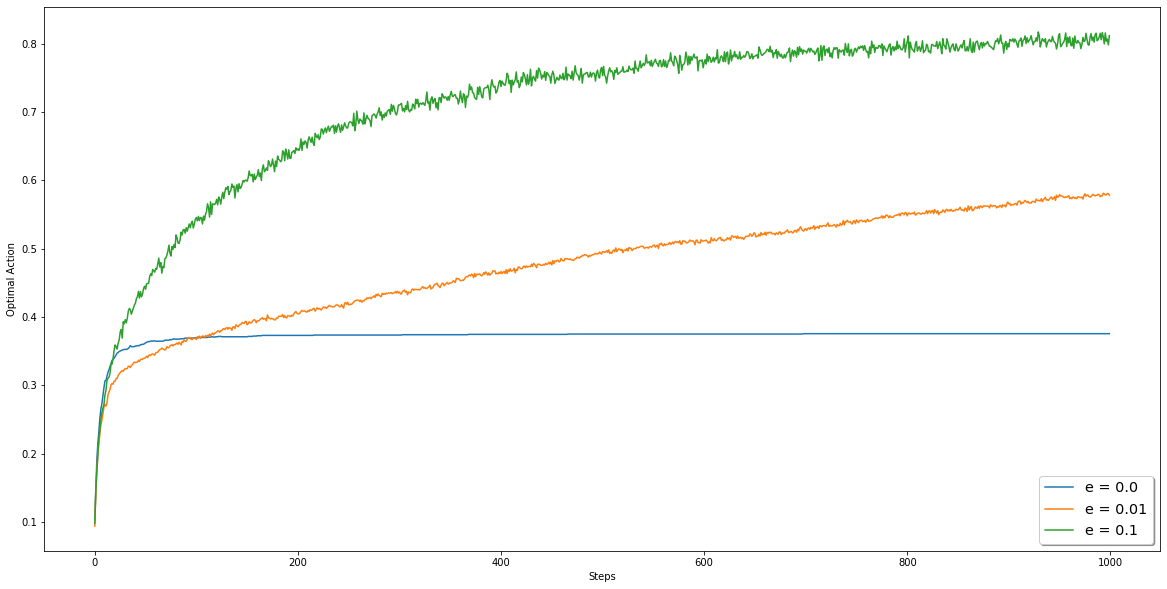

In [12]:
# Problem 1 Epsilon Greedy

key = "e = 0.0"
bandit = EpsilonGreedy(TOTAL_EXPERIMENTS, K, 0, 0.0)
avg_scores[key], optimal_action[key] = bandit.run(TIMESTEPS)

key = "e = 0.01"
bandit = EpsilonGreedy(TOTAL_EXPERIMENTS, K, 0, 0.01)
avg_scores[key], optimal_action[key] = bandit.run(TIMESTEPS)

key = "e = 0.1"
bandit = EpsilonGreedy(TOTAL_EXPERIMENTS, K, 0, 0.1)
avg_scores[key], optimal_action[key] = bandit.run(TIMESTEPS)

plot_figures(avg_scores, optimal_action, ["e = 0.0", "e = 0.01", "e = 0.1"])

In [19]:
class OptimisticInitialValues(Bandit):
    def __init__(self, batch_size, k, mean=0, epsilon=0, q=0, alpha=0):
        super(OptimisticInitialValues, self).__init__(batch_size, k, mean)
        self.epsilon = epsilon
        self.predicted_values = np.ones((batch_size, k),dtype=np.float64) * q
        self.alpha = alpha
        
    def get_actions(self):
        action_indexes = np.argmax(self.predicted_values, axis=1)
        eps = np.random.rand(self.batch_size)
        random_choice = np.random.choice(self.k, self.batch_size)
        action_indexes = np.where(eps<self.epsilon, random_choice, action_indexes)
        return action_indexes
    
    def update(self, rewards, action_indexes, n):
        self.n_actions[range(self.batch_size), action_indexes] += 1
        self.predicted_values[range(self.batch_size), action_indexes] += (rewards - self.predicted_values[range(self.batch_size), action_indexes]) * self.alpha
        
    def run(self, timesteps):
        for i in range(1, timesteps + 1):
            action_indexes = self.get_actions()
            rewards = self.get_reward(action_indexes, i)
            self.update(rewards, action_indexes, i)
        return self.average_scores, self.optimal_predictions

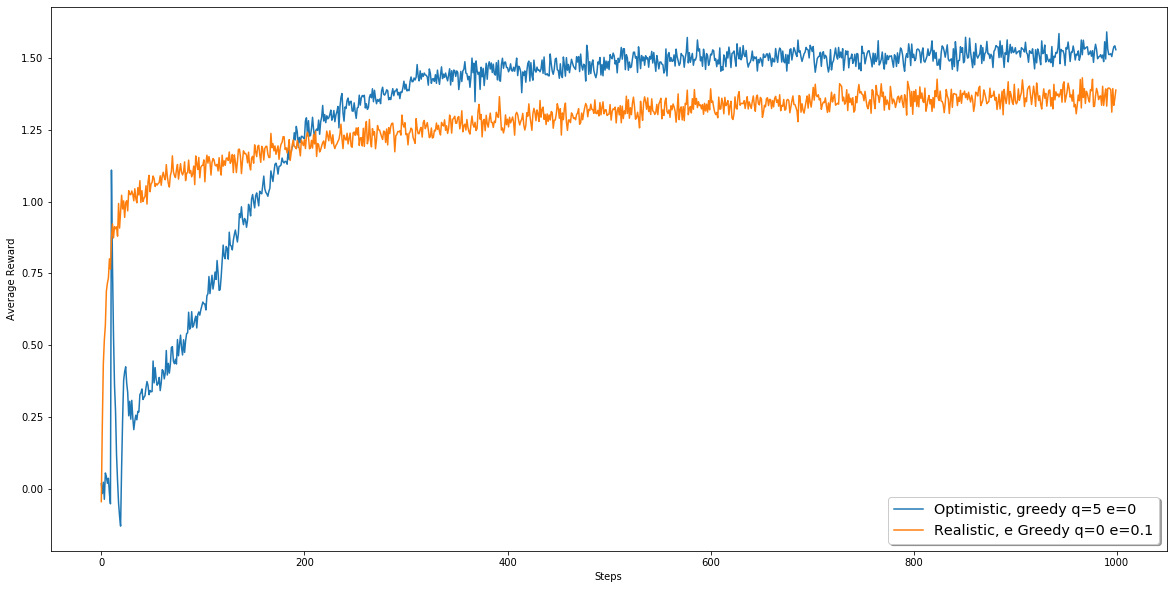

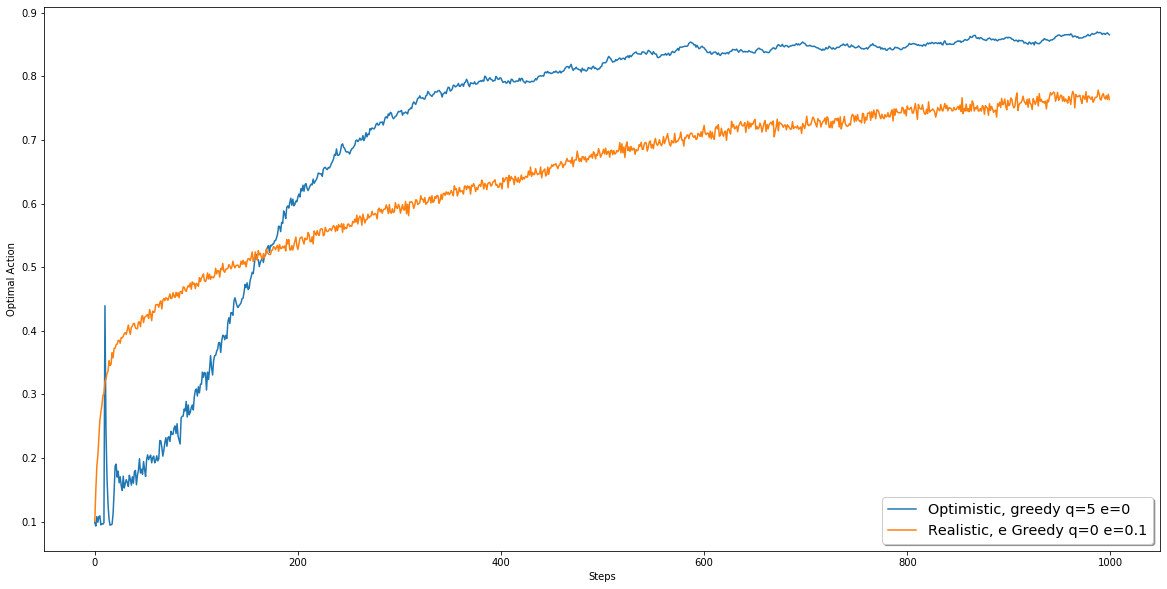

In [20]:
# Problem 2 Optimistic Initial Values
key = "Optimistic, greedy q=5 e=0"
bandit = OptimisticInitialValues(TOTAL_EXPERIMENTS, K, 0, 0.0, 5, 0.1)
avg_scores[key], optimal_action[key] = bandit.run(TIMESTEPS)

key = "Realistic, e Greedy q=0 e=0.1"
bandit = OptimisticInitialValues(TOTAL_EXPERIMENTS, K, 0, 0.1, 0, 0.1)
avg_scores[key], optimal_action[key] = bandit.run(TIMESTEPS)

plot_figures(avg_scores, optimal_action, ["Optimistic, greedy q=5 e=0", "Realistic, e Greedy q=0 e=0.1"])

In [29]:
class UCB(Bandit):
    def __init__(self, batch_size, k, mean=0, c=0):
        super(UCB, self).__init__(batch_size, k, mean)
        self.c = c
        
    def get_actions(self, i):
        action_indexes = np.argmax(self.predicted_values + self.c * np.sqrt(np.log(i)/self.n_actions + 0.00001), axis=1)
        return action_indexes
    
    def update(self, rewards, action_indexes, n):
        self.n_actions[range(self.batch_size), action_indexes] += 1
        self.predicted_values[range(self.batch_size), action_indexes] += (rewards - self.predicted_values[range(self.batch_size), action_indexes])/self.n_actions[range(self.batch_size), action_indexes]
        
    def run(self, timesteps):
        for i in range(1, timesteps + 1):
            action_indexes = self.get_actions(i)
            rewards = self.get_reward(action_indexes, i)
            self.update(rewards, action_indexes, i)
        return self.average_scores, self.optimal_predictions

/home/paullobo/anaconda3/envs/pushblock/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/paullobo/anaconda3/envs/pushblock/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


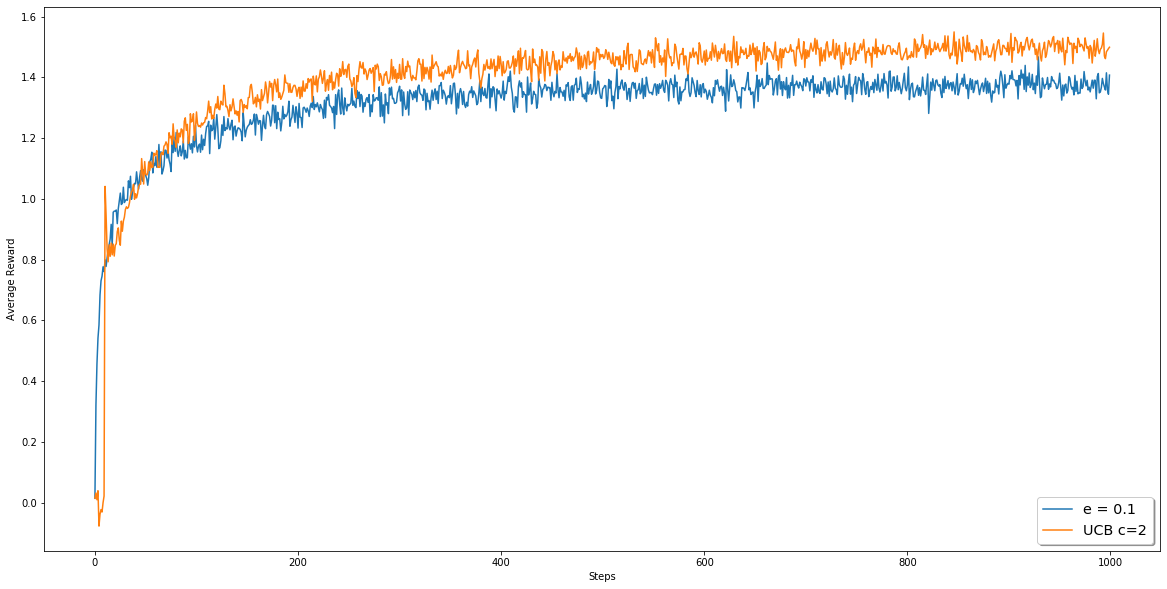

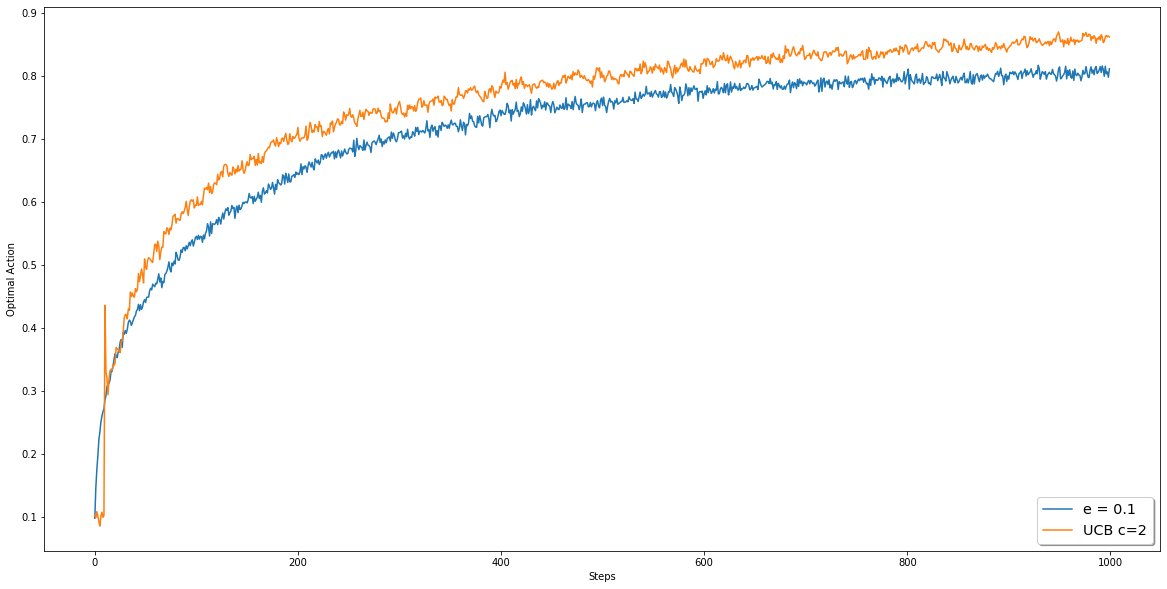

In [30]:
# UCB

key = "UCB c=2"
bandit = UCB(TOTAL_EXPERIMENTS, K, 0, 2)
avg_scores[key], optimal_action[key] = bandit.run(TIMESTEPS)

plot_figures(avg_scores, optimal_action, ["UCB c=2", "e = 0.1"])

In [40]:
class GradientBandit(Bandit):
    def __init__(self, batch_size, k, mean=0, alpha=0, baseline=False):
        super(GradientBandit, self).__init__(batch_size, k, mean)
        self.alpha = alpha
        self.action_preferences = np.zeros((batch_size, k),dtype=np.float64)
        self.average_values = np.zeros((batch_size),dtype=np.float64)
        self.baseline = baseline
        
    def get_actions(self, i):
        exp_predicted_values = np.exp(self.action_preferences)
        sum_exp = np.sum(exp_predicted_values, axis=1)
        action_probabilities = exp_predicted_values / np.expand_dims(sum_exp, axis=1)
        action_indexes = np.array([np.random.choice(self.k, p=row) for row in action_probabilities])
        return action_probabilities, action_indexes
    
    def update(self, rewards, action_indexes, n, action_prob):
        if self.baseline:
            reward = rewards - self.average_values
        else:
            reward = rewards
        update = np.expand_dims(-self.alpha * (reward),axis=1) * action_prob
        update[range(self.batch_size), action_indexes] =  self.alpha * (reward) * (1 - action_prob[range(self.batch_size), action_indexes])
        self.action_preferences += update
        self.average_values += (rewards - self.average_values)/ n
        
    def run(self, timesteps):
        for i in range(1, timesteps + 1):
            action_prob, action_indexes = self.get_actions(i)
            rewards = self.get_reward(action_indexes, i)
            self.update(rewards, action_indexes, i, action_prob)
        return self.average_scores, self.optimal_predictions

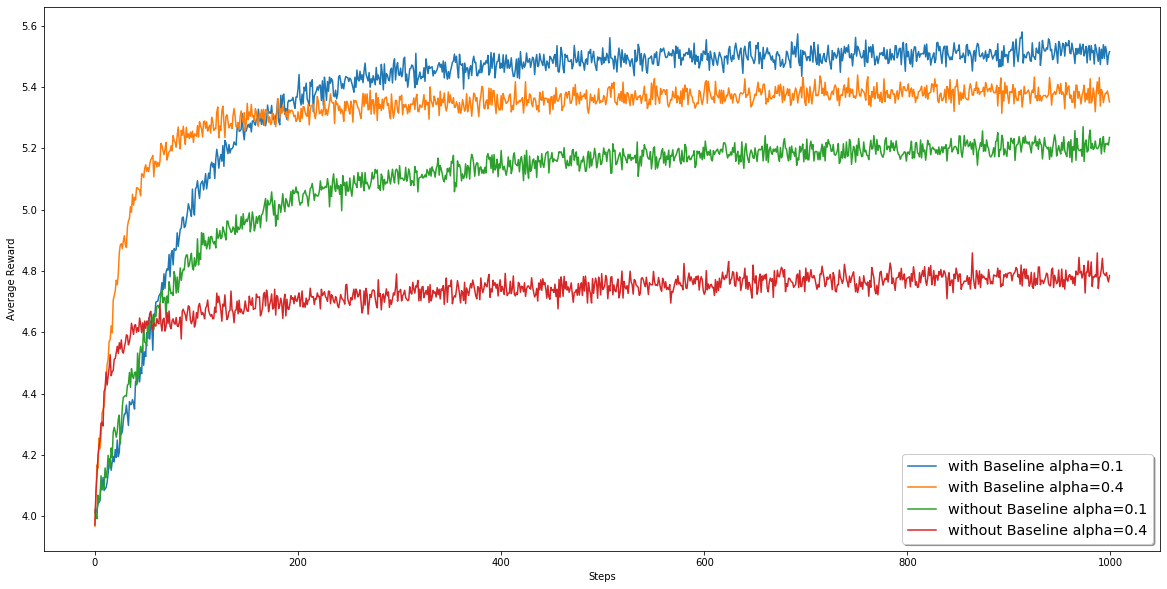

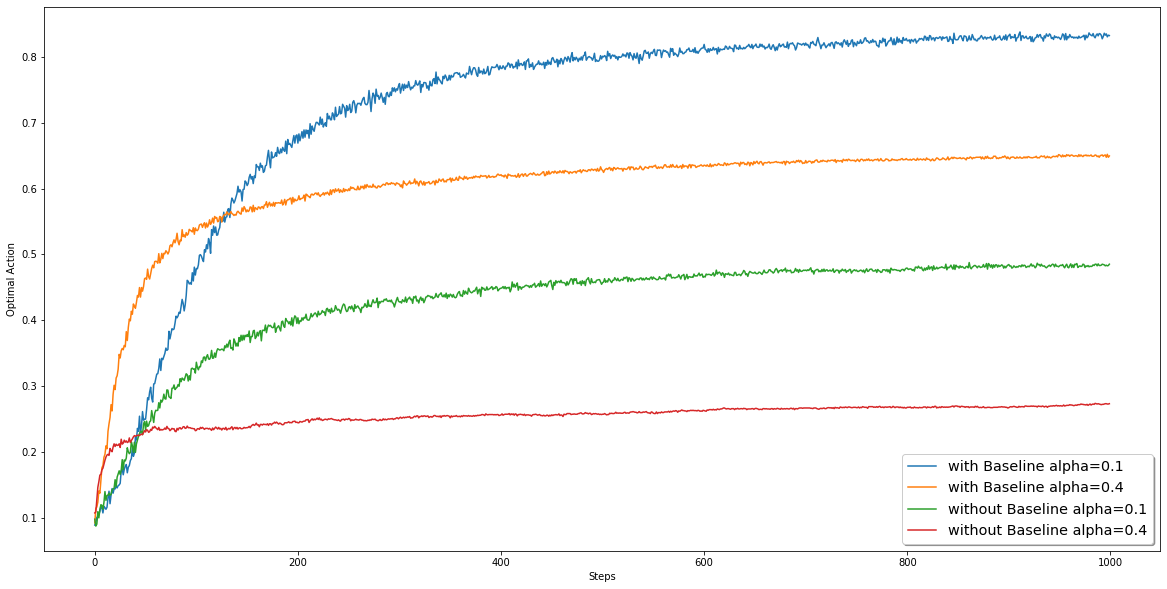

In [41]:
# Gradient Bandit

key = "with Baseline alpha=0.1"
bandit = GradientBandit(TOTAL_EXPERIMENTS, K, 4, 0.1, True)
avg_scores[key], optimal_action[key] = bandit.run(TIMESTEPS)

key = "with Baseline alpha=0.4"
bandit = GradientBandit(TOTAL_EXPERIMENTS, K, 4, 0.4, True)
avg_scores[key], optimal_action[key] = bandit.run(TIMESTEPS)

key = "without Baseline alpha=0.1"
bandit = GradientBandit(TOTAL_EXPERIMENTS, K, 4, 0.1, False)
avg_scores[key], optimal_action[key] = bandit.run(TIMESTEPS)

key = "without Baseline alpha=0.4"
bandit = GradientBandit(TOTAL_EXPERIMENTS, K, 4, 0.4, False)
avg_scores[key], optimal_action[key] = bandit.run(TIMESTEPS)

plot_figures(avg_scores, optimal_action, ["with Baseline alpha=0.1", "with Baseline alpha=0.4", "without Baseline alpha=0.1", "without Baseline alpha=0.4"])

/home/paullobo/anaconda3/envs/pushblock/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/paullobo/anaconda3/envs/pushblock/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


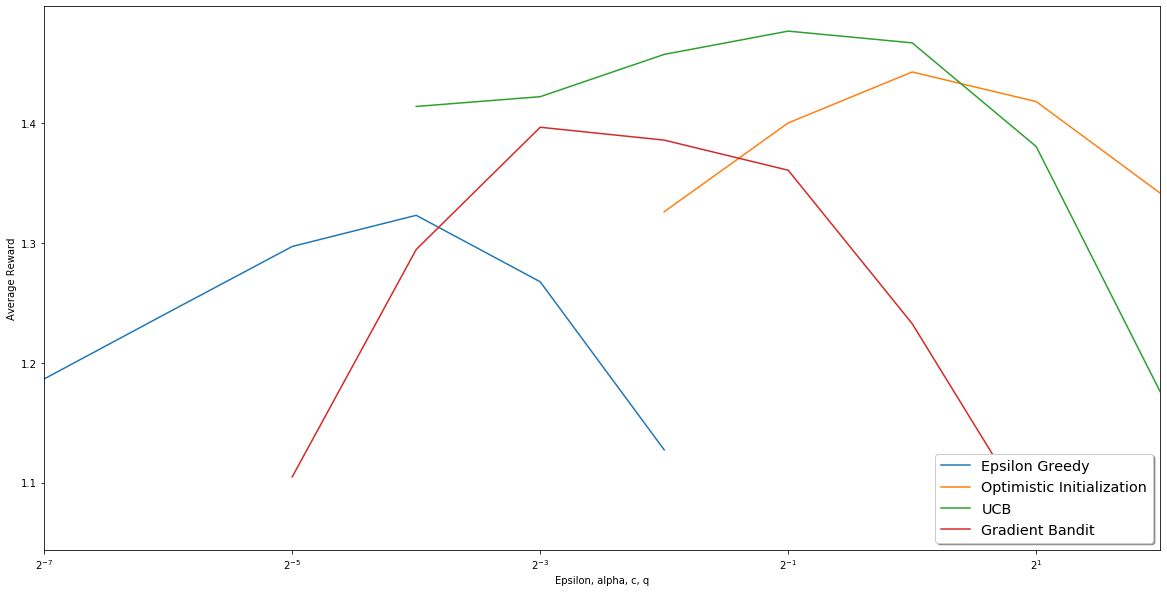

In [72]:
avg_scores = {}
optimal_action = {}
x = [2**i/128 for i in range(0, 10)]
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(111)
ax.set_xscale('log', basex=2)
ax.set_xlim([2**0/128, (2**9/128)])

# EpsilonGreedy
avg = list()
y = [2**i/128 for i in range(0, 6)]
for i in y:
    bandit = EpsilonGreedy(TOTAL_EXPERIMENTS, K, 0, i)
    avg_scores, optimal_action = bandit.run(TIMESTEPS)
    avg.append(np.mean(avg_scores))                                                
plt.plot(y, avg, label="Epsilon Greedy")

# Optimistic Initialization
avg = list()
y = [2**i/128 for i in range(5, 10)]
for i in y:
    bandit = OptimisticInitialValues(TOTAL_EXPERIMENTS, K, 0, 0.0, i, 0.1)
    avg_scores, optimal_action = bandit.run(TIMESTEPS)
    avg.append(np.mean(avg_scores))                                                
plt.plot(y, avg, label="Optimistic Initialization")


# UCB
avg = list()
y = [2**i/128 for i in range(3, 10)]
for i in y:
    bandit = UCB(TOTAL_EXPERIMENTS, K, 0, i)
    avg_scores, optimal_action = bandit.run(TIMESTEPS)
    avg.append(np.mean(avg_scores))                                                
plt.plot(y, avg, label="UCB")


# Gradient Bandit
avg = list()
y = [2**i/128 for i in range(2, 9)]
for i in y:
    bandit = GradientBandit(TOTAL_EXPERIMENTS, K, 0, i, True)
    avg_scores, optimal_action = bandit.run(TIMESTEPS)
    avg.append(np.mean(avg_scores))                                                
plt.plot(y, avg, label="Gradient Bandit")

plt.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.xlabel('Epsilon, alpha, c, q')
plt.ylabel('Average Reward')
plt.show()